In [1]:
# Data Loader

import numpy as np
import pandas as pd
import pickle
import os


class Bunch(dict):
    def __init__(self, **kwargs):
        super().__init__(kwargs)

        for key, value in kwargs.items():
            setattr(self, key, value)

def _convert_to_numpy_array(dataframes: list[pd.DataFrame], target: pd.Series):
    
    numpy_data = []
    for df in dataframes:
        numpy_data.append(df.values)

    return np.array(numpy_data), target.to_numpy()
        
def load_tsa_data(return_X_y=False):

    with open('tsa_dataset/description.txt', 'r') as fdescr:
        descr = fdescr.read()

    data_filename = os.path.join('tsa_dataset/data', 'tsa_data.pkl')
    with open(data_filename, 'rb') as file:
        data, target = pickle.load(file) # returns tuple[list[pd.Dataframe], pd.Series]

    feature_names = data[0].columns.to_list() # list[str]
    target_names = ['stable', 'unstable']

    data, target = _convert_to_numpy_array(data, target)

    if return_X_y:
        return data, target

    return Bunch(
        data=data,
        target=target,
        feature_names=feature_names,
        target_names=target_names,
        DESCR=descr,
        filename=data_filename
    )

In [2]:
bunch = load_tsa_data()

# print(bunch.DESCR)
# print(bunch.filename)
# print(bunch.data[:3])
# print(bunch.target[:3])
# print(bunch.feature_names)
# print(bunch.target_names)

In [3]:
data, target = bunch.data, bunch.target

In [4]:
print(bunch.feature_names)

['G01 P in MW', 'G02 P in MW', 'G03 P in MW', 'G04 P in MW', 'G05 P in MW', 'G06 P in MW', 'G07 P in MW', 'G08 P in MW', 'G09 P in MW', 'G10 P in MW', 'G01 ut in p.u.', 'G02 ut in p.u.', 'G03 ut in p.u.', 'G04 ut in p.u.', 'G05 ut in p.u.', 'G06 ut in p.u.', 'G07 ut in p.u.', 'G08 ut in p.u.', 'G09 ut in p.u.', 'G10 ut in p.u.', 'G01 ie in p.u.', 'G02 ie in p.u.', 'G03 ie in p.u.', 'G04 ie in p.u.', 'G05 ie in p.u.', 'G06 ie in p.u.', 'G07 ie in p.u.', 'G08 ie in p.u.', 'G09 ie in p.u.', 'G10 ie in p.u.', 'G01 xspeed in p.u.', 'G02 xspeed in p.u.', 'G03 xspeed in p.u.', 'G04 xspeed in p.u.', 'G05 xspeed in p.u.', 'G06 xspeed in p.u.', 'G07 xspeed in p.u.', 'G08 xspeed in p.u.', 'G09 xspeed in p.u.', 'G10 xspeed in p.u.', 'G01 firel in deg', 'G02 firel in deg', 'G03 firel in deg', 'G04 firel in deg', 'G05 firel in deg', 'G06 firel in deg', 'G07 firel in deg', 'G08 firel in deg', 'G09 firel in deg', 'G10 firel in deg']


In [5]:
data.shape 
# 12852 sets of data
# 60 - 0.6s, step size = 0.01s
# 50 - 50 features

(12852, 60, 50)

In [6]:
target.shape
# 1 - stable; 0 - unstable

(12852,)

In [17]:
X = data
y = target

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,random_state=2)
from sklearn.utils import compute_sample_weight
sw = compute_sample_weight('balanced',y_train)

### Simple CNN

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Assuming you already have X and y loaded:
# X.shape = (12852, 60, 50)
# y.shape = (12852,)

# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60, 50)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


/opt/anaconda3/envs/CNN-TSA/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 58, 64)         │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 58, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       213,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,385 (970.25 KB)

 Trainable params: 248,001 (968.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9260 - loss: 0.1954 - val_accuracy: 0.8917 - val_loss: 0.7388
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9829 - loss: 0.0614 - val_accuracy: 0.9550 - val_loss: 0.1388
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9788 - loss: 0.0600 - val_accuracy: 0.9789 - val_loss: 0.0501
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9855 - loss: 0.0394 - val_accuracy: 0.9850 - val_loss: 0.0341
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9828 - loss: 0.0473 - val_accuracy: 0.9811 - val_loss: 0.0516
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9862 - loss: 0.0353 - val_accuracy: 0.9744 - val_loss: 0.0691
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9869 - loss: 0.0346 - val_accuracy: 0.9911 - val_loss: 0.0275
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9860 - loss: 0.0334 - val_accuracy: 0.

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[1509   70]
 [   3 2274]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       1.00      0.96      0.98      1579
      Stable       0.97      1.00      0.98      2277

    accuracy                           0.98      3856
   macro avg       0.98      0.98      0.98      3856
weighted avg       0.98      0.98      0.98      3856

ROC AUC Score: 0.9993


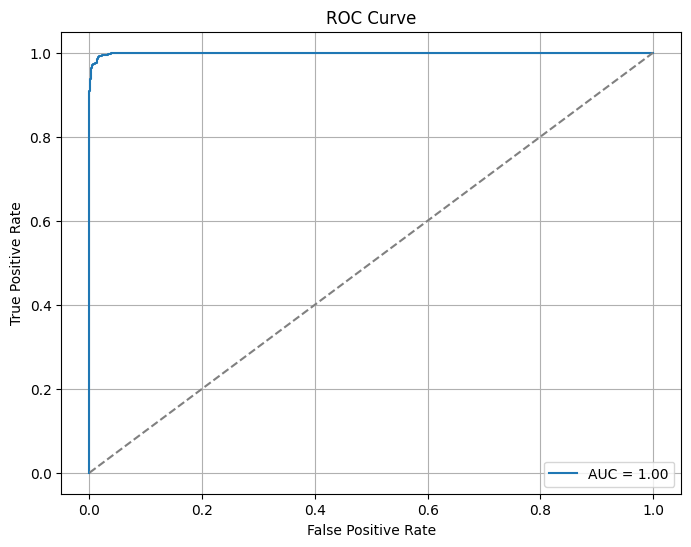

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities and class labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Unstable", "Stable"]))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Conv2D Grouped CNN

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_80 (InputLayer)     │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 60, 10, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 10, 32)     │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 5, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 5, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 5, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 5, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 15, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,369 (1.02 MB)

 Trainable params: 266,177 (1.02 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8884 - loss: 0.3234 - val_accuracy: 0.9747 - val_loss: 0.0737
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9711 - loss: 0.0712 - val_accuracy: 0.9767 - val_loss: 0.0600
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9783 - loss: 0.0549 - val_accuracy: 0.9801 - val_loss: 0.0498
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9804 - loss: 0.0460 - val_accuracy: 0.9878 - val_loss: 0.0298
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9798 - loss: 0.0457 - val_accuracy: 0.9830 - val_loss: 0.0428
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9789 - loss: 0.0473 - val_accuracy: 0.9689 - val_loss: 0.0734
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9823 - loss: 0.0437 - val_accuracy: 0.9864 - val_loss: 0.0323
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9844 - loss: 0.0381 - val_accu

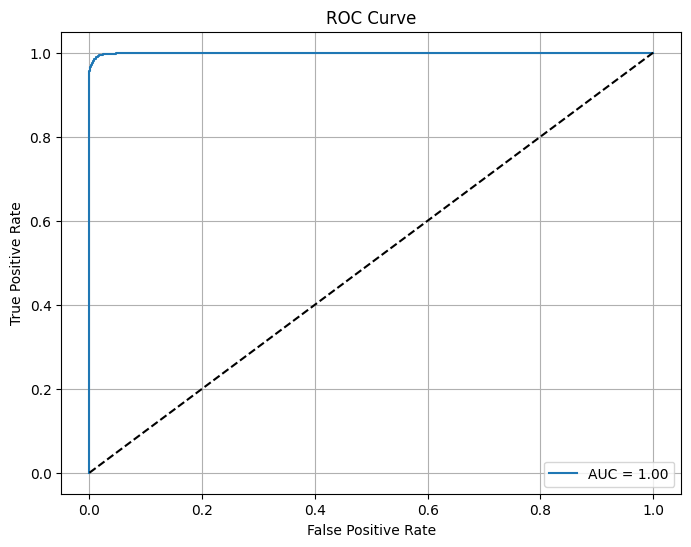

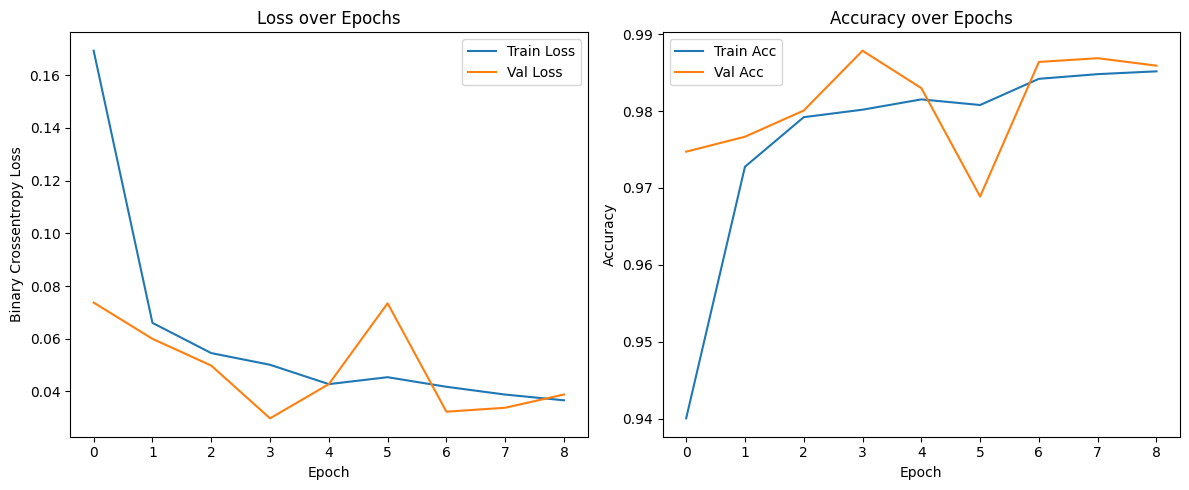

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Flatten,
                                     Dense, BatchNormalization, Reshape)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

# Assuming you have your dataset ready:
# X.shape = (12852, 60, 50)
# y.shape = (12852,)
# Replace this with actual loading if needed

# Example: X, y = load_your_data()
# For testing purposes:
# X = np.random.rand(12852, 60, 50)
# y = np.random.randint(0, 2, size=(12852,))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the model
input_layer = Input(shape=(60, 50))  # 60 time steps, 50 features
x = Reshape((60, 10, 5))(input_layer)  # reshape to (time, generators, channels)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
print("\nEvaluating on test set:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

# Predict and evaluate
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Unstable", "Stable"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Parallel

In [13]:
import os
import tensorflow as tf

# If you have multiple machines, you can use MultiWorkerMirroredStrategy
# strategy = tf.distribute.MultiWorkerMirroredStrategy()

# For one machine with multiple GPUs:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [19]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Im2ColConv2D(Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding='SAME', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.strides = [1, *strides, 1]
        self.padding = padding

    def build(self, input_shape):
        in_channels = int(input_shape[-1])
        k_h, k_w = self.kernel_size
        # weight shape: [k_h * k_w * in_channels, filters]
        self.kernel = self.add_weight(
            shape=(k_h * k_w * in_channels, self.filters),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.filters,), initializer='zeros', trainable=True, name='bias'
        )

    def call(self, inputs):
        # im2col via extract_patches
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, *self.kernel_size, 1],
            strides=self.strides,
            rates=[1,1,1,1],
            padding=self.padding
        )
        # patches shape: [batch, out_h, out_w, k_h*k_w*in_channels]
        batch, oh, ow, dim = tf.unstack(tf.shape(patches))
        # reshape to [batch*out_h*out_w, k_h*k_w*in_channels]
        patches_flat = tf.reshape(patches, [batch * oh * ow, dim])
        # matrix multiply -> [batch*out_h*out_w, filters]
        outputs_flat = tf.matmul(patches_flat, self.kernel) + self.bias
        # reshape back to [batch, out_h, out_w, filters]
        outputs = tf.reshape(outputs_flat, [batch, oh, ow, self.filters])
        return outputs

In [20]:
with strategy.scope():
    # Inputs and reshape
    inp = tf.keras.Input(shape=(60,50))
    x = tf.keras.layers.Reshape((60,10,5))(inp)

    # Replace Conv2D with Im2ColConv2D
    x = Im2ColConv2D(32, (3,3), padding='SAME')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = Im2ColConv2D(64, (3,3), padding='SAME')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inp, out)
    optimizer = tf.keras.optimizers.Adam()
    # Under the hood this optimizer is wrapped so gradients from each replica are all-reduced
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 60, 10, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ im2_col_conv2d_4 (Im2ColConv2D) │ (None, 60, 10, 32)     │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 5, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 5, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ im2_col_conv2d_5 (Im2ColConv2D) │ (None, 30, 5, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 5, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 15, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,369 (1.02 MB)

 Trainable params: 266,177 (1.02 MB)

 Non-trainable params: 192 (768.00 B)

In [21]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit — this will shard each batch of 64 across all GPUs
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {loss:.4f}, Test acc: {acc:.4f}")

Epoch 1/50


2025-05-01 02:27:07.179408: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7880 - loss: 0.4766

2025-05-01 02:27:08.932613: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7897 - loss: 0.4731 - val_accuracy: 0.9611 - val_loss: 0.1019
Epoch 2/50
  9/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9546 - loss: 0.1169

2025-05-01 02:27:09.218778: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9625 - loss: 0.1044 - val_accuracy: 0.9750 - val_loss: 0.0645
Epoch 3/50
  9/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9759 - loss: 0.0843

2025-05-01 02:27:11.027252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9732 - loss: 0.0777 - val_accuracy: 0.9650 - val_loss: 0.0897
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9794 - loss: 0.0540 - val_accuracy: 0.9872 - val_loss: 0.0310
Epoch 5/50
  9/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9781 - loss: 0.0628

2025-05-01 02:27:14.714320: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9787 - loss: 0.0519 - val_accuracy: 0.9633 - val_loss: 0.1091
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9799 - loss: 0.0548 - val_accuracy: 0.9872 - val_loss: 0.0293
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9839 - loss: 0.0438 - val_accuracy: 0.9789 - val_loss: 0.0602
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9805 - loss: 0.0494 - val_accuracy: 0.9856 - val_loss: 0.0323
Epoch 9/50
  9/113 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9873 - loss: 0.0324

2025-05-01 02:27:22.484414: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9839 - loss: 0.0389 - val_accuracy: 0.9878 - val_loss: 0.0249
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9813 - loss: 0.0414 - val_accuracy: 0.9756 - val_loss: 0.0682
Epoch 11/50
 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9763 - loss: 0.0516

KeyboardInterrupt: 